# GenVeg Main Script
## Test dune vegetation implementation
GenVeg is a generalized vegetation growth model that simulates growth due to
photosynthesis as well as processes that control vegetation distribution such
as mortality, senescence, dispersal, and colonization. The model utilizes a 
mixture of existing and new Landlab components to setup the model, simulates
relevant vegetation community dynamics with the local environment, and analyzes
results of the simulation. 

## Main model control set up
### Import components

In [1]:
import numpy as np, pandas as pd
import os, tempfile
from pathlib import Path
from datetime import date
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection, LineCollection
from landlab import RasterModelGrid, imshow_grid, load_params
from landlab.data_record import DataRecord
from landlab.components.genveg import VegParams, GenVeg
from landlab.io.netcdf import write_netcdf, read_netcdf
from scipy.io import netcdf_file
#from noaa_coops import Station

### Define time controls

This sets up a one-year run with a daily timestep.

In [2]:
sim_start_date = np.datetime64('2010-01-01')
sim_end_date = np.datetime64('2019-09-10')
veg_time_step_d = 1
env_time_step_d = 1
dt=np.timedelta64(min([veg_time_step_d,env_time_step_d]),'D')
run_length_d=(sim_end_date-sim_start_date).astype(int)
print(run_length_d)

3539


### Define filenames for input files
##### *Note should be located in same folder as this .ipynb

In [3]:
working_dir_path=Path.cwd()
veg_input_file = 'GenVeg_Dune_Simulation.xlsx'

### Read in parameter and data input files
Identify model processes to be included so all required parameters are defined and calculated

In [4]:
inp_file_path=working_dir_path.joinpath(veg_input_file)
VegParams(fpath=inp_file_path)
vegparams=load_params('veg_params.yml')


In [5]:
print(vegparams)

{'BTS': {'col_params': {'prob_colonization': 0.01, 'time_to_colonization': 365}, 'dispersal_params': {'max_dist_dispersal': 0.4, 'min_size_dispersal': 0.5, 'unit_cost_dispersal': 1.2}, 'duration_params': {'growing_season_end': 305, 'growing_season_start': 144, 'max_age': 1000, 'peak_biomass': 227, 'reproduction_end': 250, 'reproduction_start': 180, 'senescence_start': 273}, 'grow_params': {'allocation_method': 'Poorter', 'glucose_requirement': {'leaf': 1.463, 'reproductive': 1.414, 'root': 1.444, 'stem': 1.513}, 'growth_max_biomass': 13.899999999999999, 'growth_min_biomass': 0.06222222222222222, 'incremental_nsc': {'leaf': [1.25, 0, -1, 0.5], 'reproductive': [1.5625, -1.875, 0.0625, 2.5], 'root': [1.25, -2.5, 0, 2], 'stem': [0, -0.5, 0, 0.5]}, 'max_nsc_content': {'leaf': 0.36629, 'reproductive': 0.36643, 'root': 0.36643, 'stem': 0.30964}, 'min_nsc_content': {'leaf': 0.01548, 'reproductive': 0.01071, 'root': 0.01071, 'stem': 0.0075}, 'nsc_content': {'leaf': 0.17396, 'reproductive': 0.21

In [6]:
env_fname='data\POWER_Point_Daily_20100101_20191231_045d67N_0123d94W_LST.csv'
env_data_file_path = working_dir_path.joinpath(env_fname)
env_data=np.genfromtxt(env_data_file_path, dtype={'names': ('year','doy','clear_par_Wm^-2','par_Wm^-2','max_temp_C','min_temp_C','precip_mm','wind_sp','wid_dir','root_wetness'),'formats': ('int', 'int', 'f8', 'f8','f8','f8','f8','f8', 'f8', 'f8', 'f8')}, delimiter=',', skip_header=18) 

This code block reads in 6-minute water level data from NOAA CO-OPs and calculates a daily mean. Only run once to save the daily csv.

In [7]:
#AC=Station(id=8534720)
#df_water_levels = AC.get_data(
#    begin_date="20100101",
#    end_date="20191231",
#    product="water_level",
#    datum="MSL",
#    units="metric",
#    time_zone="lst")

#df_water_levels.head()

In [8]:
#df_water_levels.drop(['s','f','q'], axis=1, inplace=True)
#daily_wl = df_water_levels.resample('1D').mean()
#daily_wl.to_csv('D:\\Python\\landlab\\notebooks\\GenVeg\\data\\water_level.csv', index=False)

Read in the daily water level csv and construct a 7-day rolling average of water levels as a Numpy data array.

In [9]:
water_level_filename='data\water_level.csv'
water_level_file_path=working_dir_path.joinpath(water_level_filename)
df_water_levels=pd.read_csv(water_level_file_path)
df_water_levels.interpolate(method='linear', inplace=True)
df_WL_MA=df_water_levels.rolling(7)
water_level=df_water_levels['v'].to_numpy()

For this implementation, we are taking a snippet of the existing DOONIES Island Beach State Park initial domain. Ideally, you would read in a raster topobathy file. This file must be rotated so the ocean is to left and the shoreline is parallel to the y-axis. This is the convention of many cross-shore morphology models but in the future the distance to shore function defined in this notebook can be expanded to rotate the file to the correct orientation.

In [10]:
grid_elev=np.array([
-0.1928368,0.002336806,0.2527808,0.4474464,0.7190232,0.9187687,1.215136,1.431138,1.687068,1.882648,2.092655,2.256739,2.479954,2.701747,2.986938,3.585566,4.65267,5.686654,6.538773,6.87446,6.985254,6.662318,6.724193,6.803441,6.915912,6.745834,6.621476,6.344412,6.305398,5.864048,
-0.2033016,0.027432,0.18288,0.5480304,0.6114288,0.9976104,1.147267,1.50053,1.645615,1.915058,2.08727,2.275637,2.40731,2.756916,2.941015,3.262884,4.552798,6.14233,6.364834,7.109155,7.149389,7.020154,6.970167,7.130491,6.918655,6.73608,6.69798,6.50108,6.321552,6.105145,
-0.2182368,0.0393192,0.2023872,0.4745736,0.5544312,1.008888,1.149401,1.504188,1.655369,1.89799,2.105558,2.306422,2.464308,2.789225,2.94894,3.213202,3.951427,6.163666,6.351727,7.000341,7.175601,7.028993,7.013144,7.004914,6.978701,6.901891,6.844589,6.463894,6.34106,6.149035,
-0.2584704,0.04572,0.1524,0.5205984,0.6096,1.023214,1.21158,1.479499,1.655064,1.98882,2.197913,2.396033,2.558186,2.817876,2.870911,3.130601,3.53629,6.078321,6.180735,6.859829,7.010096,6.894271,6.924751,6.959194,6.890614,6.94944,6.938772,6.399886,6.315761,5.94299,
-0.2237232,0.0972312,0.2292096,0.6007608,0.6184392,1.099414,1.258824,1.589837,1.754734,2.036369,2.161032,2.415235,2.610307,2.827325,2.948635,3.154985,3.353714,5.825033,6.157265,6.656832,6.97992,6.921399,6.939686,6.915607,6.85739,6.900063,6.892138,6.430975,6.267298,6.002427,
-0.1801368,0.0420624,0.2493264,0.6403849,0.7501128,1.154278,1.332891,1.666037,1.870558,2.173529,2.342693,2.512771,2.677363,2.792273,2.871216,3.112008,3.324454,5.696407,6.104535,6.589167,6.720231,7.064045,6.970777,6.856476,6.872326,6.702247,6.476696,6.156655,6.049366,5.864048,
-0.2770632,0.07955281,0.25908,0.6525768,0.733044,1.194816,1.418844,1.72974,1.901038,2.156155,2.396642,2.603906,2.683764,2.791358,2.887066,3.043123,3.281172,5.27304,5.968289,6.712001,7.053072,7.083247,6.924447,6.717793,6.733032,6.419088,6.252363,6.051499,5.923179,5.823204,
-0.1917192,0.1277112,0.2688336,0.6504433,0.7318248,1.254557,1.453286,1.86629,2.083918,2.350618,2.504847,2.604211,2.579218,2.731008,2.805989,3.045257,3.231185,4.619244,5.366309,6.59892,7.016191,7.228941,7.070446,6.715049,6.49925,6.117032,5.89026,5.665318,5.719572,5.817413,
-0.2234184,0.1197864,0.2639568,0.6574537,0.7427976,1.26553,1.483157,1.884274,2.062886,2.284171,2.386279,2.538984,2.579827,2.695956,2.793187,3.027883,3.20741,4.701845,5.63819,6.676949,6.959803,7.325868,7.168896,6.741567,6.477305,6.062777,5.837224,5.59308,5.525719,5.715305,
-0.1423416,0.1045464,0.2340864,0.6068568,0.679704,1.160983,1.363675,1.702613,1.874825,2.155546,2.291182,2.488692,2.494788,2.658161,2.73619,2.969971,3.189427,4.169969,5.011827,6.572402,6.876288,7.343546,7.232904,6.787896,6.340755,6.123737,5.990234,5.648859,5.568391,5.678424,
-0.1697736,0.09570721,0.2188464,0.595884,0.6931152,1.106729,1.358494,1.685239,1.825142,2.093671,2.258263,2.427427,2.481377,2.625852,2.703576,3.010509,3.153461,3.971544,4.618939,6.444386,6.772351,7.306361,7.251801,6.769303,6.444691,6.167933,6.059424,5.871363,5.775351,5.783276,
-0.2100072,0.1222248,0.2136648,0.5727192,0.6129528,1.001268,1.169518,1.516075,1.66177,1.968094,2.092147,2.311603,2.407006,2.592019,2.686812,2.942539,3.141574,3.594507,4.324502,6.266993,6.640983,7.199071,7.231076,7.006743,7.032041,6.542227,6.377026,6.12709,6.008828,5.785409,
-0.1880616,0.0841248,0.1831848,0.5376672,0.5574792,0.9506712,1.138733,1.464564,1.635557,1.887626,2.04917,2.27015,2.379574,2.597201,2.691993,2.934005,3.10134,3.496666,4.080053,6.157265,6.567526,7.068312,7.170724,6.912864,6.763817,6.320333,6.27126,6.361176,6.175858,5.765902,
-0.1441704,0.10668,0.225552,0.4453128,0.5047488,0.8388096,1.030529,1.353922,1.529182,1.764487,1.929689,2.136038,2.261616,2.496007,2.599334,2.908097,3.0861,3.317139,3.660648,5.831434,6.19628,6.896405,6.931457,7.434682,7.669378,7.43712,7.25485,6.894881,6.79765,6.512967,
-0.1283208,0.1024128,0.2185416,0.4773168,0.5172456,0.8189976,1.011936,1.277417,1.439875,1.727911,1.981505,2.129942,2.230222,2.451811,2.577693,2.843784,3.031236,3.318358,3.547262,6.124956,6.46938,6.930847,6.975957,7.890053,7.908036,7.556906,7.371284,6.856476,6.771132,6.448044,
-0.0905256,0.050292,0.1557528,0.4261104,0.4959096,0.7805929,0.9086088,1.198778,1.345082,1.6383,1.83703,2.089099,2.189378,2.458517,2.588666,2.82763,3.007157,3.241853,3.374136,6.511747,6.813499,7.29996,7.400239,7.94766,7.881214,7.680655,7.513625,7.075017,6.899148,6.578194,
-0.202692,0.0124968,0.1252728,0.397764,0.4507992,0.740664,0.894588,1.199693,1.360627,1.634338,1.841907,2.107082,2.21681,2.459736,2.562149,2.84226,3.001366,3.224174,3.282696,6.367272,6.526073,7.259117,7.431938,7.716317,7.62762,7.523074,7.359701,7.000037,6.857086,6.583985,
-0.2444496,0.0423672,0.179832,0.416052,0.4605528,0.7187184,0.8476488,1.136904,1.261262,1.632204,1.873301,2.100377,2.210105,2.44541,2.553919,2.756611,2.986735,3.234538,3.317139,6.04266,6.048756,6.913474,7.030517,7.280453,7.214312,6.962547,6.841541,6.68335,6.678778,6.490411,
-0.275844,0.0521208,0.1822704,0.4614672,0.5297424,0.7479792,0.8842248,1.132332,1.320394,1.604162,1.855622,2.139391,2.227479,2.483206,2.586838,2.82001,2.991002,3.145231,3.273247,5.810402,5.782056,6.662928,6.830873,7.204253,7.061606,6.811061,6.686093,6.535827,6.556248,6.465722,
-0.3834384,0.0310896,0.1999488,0.5081016,0.5690616,0.8095488,0.905256,1.231392,1.411529,1.761744,1.985162,2.164385,2.276246,2.540203,2.636215,2.816962,2.952902,3.170834,3.271418,5.628437,5.89788,6.414211,6.508395,6.834835,6.878727,6.734251,6.514185,6.256325,6.227674,6.302959
])
grid_elev.size

600

### Set up model grid using landlab RasterModelGrid functions

- Create the model grid
- Initialize the air temperature driver across the grid
- Initialize the photosynthetically active radiation across the grid
- Initialize the elevation relative to sea level
- Initialize mortality variables: elevation above water level and distance to shore
- Initialize vegetation percent cover and randomly assign vegetation species in each grid cell

##### **Note variable names should be consistent with landlab standards

In [11]:
#Create grid 22x32 node grid with 2 m node spacing and xy of origin in lat long roughly corresponding to Island Beach State Park
pg = RasterModelGrid((22, 32), 2, xy_of_reference=(-74.08,39.79))
pg.axis_units = ('m', 'm')

#Create dummy datasets of mean daily temperature, PAR, distance to the shore, and elevation relative to sea level
maxtemp=env_data['max_temp_C']
mintemp = env_data['min_temp_C']
NJ_avg_par=env_data['par_Wm2']
soil_moisture_frac = env_data['root_wetness']                

#Initialize with a dummy data sets 
_ = pg.add_field('air__max_temperature', maxtemp[0]*np.ones(pg.number_of_cells), at='cell', units='C' )
_ = pg.add_field('air__min_temperature', mintemp[0]*np.ones(pg.number_of_cells), at='cell', units='C' )
_ = pg.add_field('radiation__total_par', NJ_avg_par[0]*np.ones(pg.number_of_cells), at='cell', units='W/m^2')
_ = pg.add_field('surface__potential_evapotranspiration_rate', np.ones(pg.number_of_cells), at='cell', units='mm/d')
_ = pg.add_field('soil_water__volume_fraction', soil_moisture_frac[0]*np.ones(pg.number_of_cells), at='cell', units='m^3/m^3'), 
_ = pg.add_field('topographic__elevation', grid_elev, at='cell', units='m_MSL')
_ = pg.add_field('water_surface__elevation', water_level[0]*np.ones(pg.number_of_cells), at='cell', units='m')

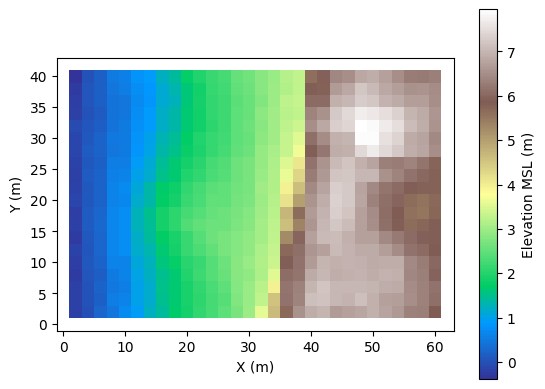

In [12]:
imshow_grid(pg, 'topographic__elevation', at='cell',colorbar_label='Elevation MSL (m)', cmap='terrain')

These next cells calculate the distance to shore. First we define the function and then apply it. Note the function assumes the elevation grid is in the correct orientation.

This function calculates the distance to shore from a grid input.

In [13]:
def calc_dist2shore(rmg):
    core_nodes=rmg.core_nodes
    x=rmg.node_axis_coordinates(0)
    x=x[core_nodes]
    y=rmg.node_axis_coordinates(1)
    y=y[core_nodes]
    z= rmg["cell"]["topographic__elevation"] - rmg['cell']['water_surface__elevation']
    num_rows=np.unique(x)
    dist2shore=np.zeros_like(grid_elev)
    for row in num_rows:
        row_loc=np.nonzero(x==row)
        row_x=x[row_loc]
        row_y=y[row_loc]
        row_z=z[row_loc]
        inundated=np.nonzero(row_z<0)
        shore_cell_idx=inundated[-1]
        if shore_cell_idx.size <=0:
            m=(row_z[1]-row_z[0])/(row_y[1]-row_y[0])
            b=row_z[0]-m*row_y[0]
            shore_y=(0-b)/m

        else:
            wet_cell=shore_cell_idx[-1]
            dry_cell=wet_cell+1
            shore_z_wet=row_z[wet_cell]
            shore_y_wet=row_y[wet_cell]
            shore_z_dry=row_z[dry_cell]
            shore_y_dry=row_y[dry_cell]
            m=(shore_z_wet-shore_z_dry)/(shore_y_wet-shore_y_dry)
            b=shore_z_wet-m*shore_y_wet
            shore_y=(0-b)/m

        shore_dist=row_y-shore_y
        dist2shore[row_loc]=shore_dist
    return dist2shore

Calculate distance to shore and save as Distance to shore variable in raster model grid object.

In [14]:
dist2shore=calc_dist2shore(pg)
_ = pg.add_field('Distance to shore', dist2shore, at='cell', units='m', clobber=True)
relative_elevation = pg.at_cell['topographic__elevation'] - pg.at_cell['water_surface__elevation']
_ = pg.add_field('elevation__above_WL', relative_elevation, at='cell', units='m', clobber=True)


Now we visualize the grid initial conditions and save some of the plots for later use. 

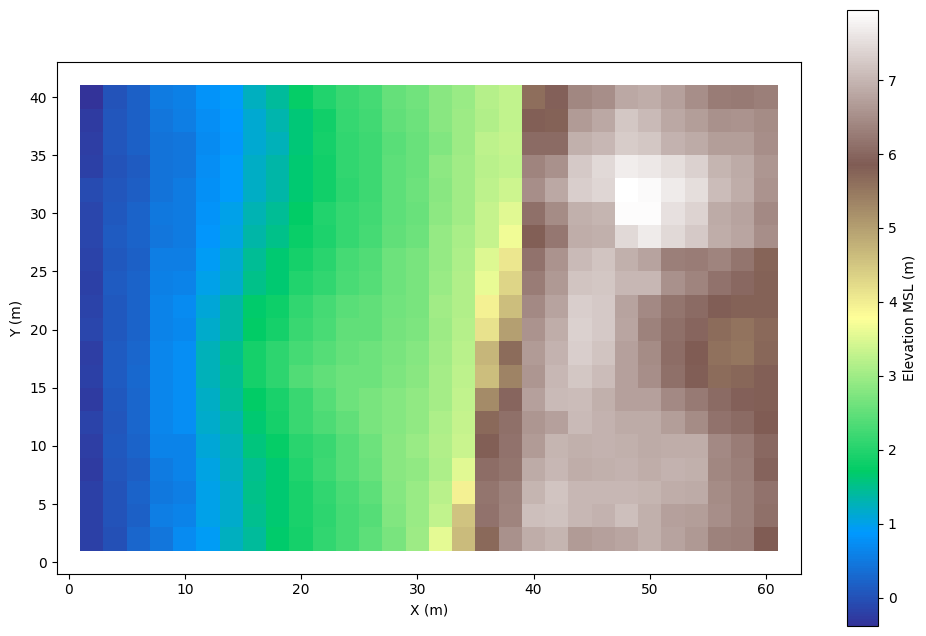

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
imshow_grid(pg, 'topographic__elevation', at='cell',colorbar_label='Elevation MSL (m)', cmap='terrain')

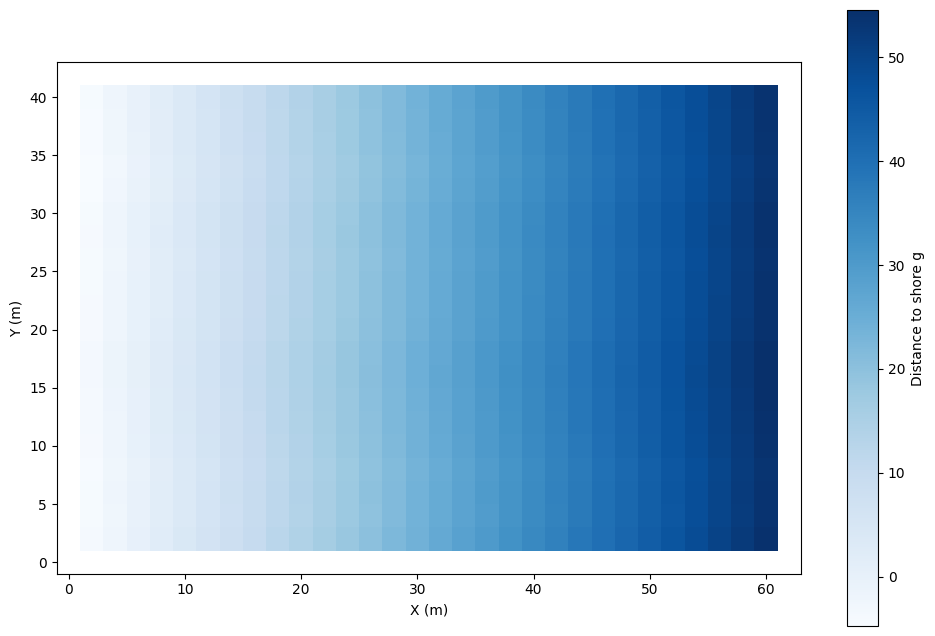

In [16]:
fig, ax = plt.subplots(figsize=(12,8))
imshow_grid(pg, 'Distance to shore', at='cell', colorbar_label='Distance to shore g', cmap='Blues')

Here we initialize a cell percent cover across the entire grid. This means plants will be placed in locations we know they will not survive. Initial percent cover is randomly assigned between 0 and 20% and cells are randomly assigned to be populated by just dune builders, just burial tolerant stabilizers, or a mix of the two.

In [17]:
#Initialize plant functional type as burial tolerant stabilizer or dune builder and randomly place on grid
_ = pg.add_field('vegetation__cover_fraction', np.random.default_rng().uniform(low=0.0, high=0.2, size=pg.number_of_cells), at='cell', clobber=True)
plant_list=[['DB','null'],['DB','BTS'],['null','BTS']]
_ = pg.add_field('vegetation__plant_species',np.random.default_rng().choice(plant_list,pg.number_of_cells), at='cell', clobber=True)


### Initialize the GenVeg component and visualize initial plant metrics.

Initialize dune GenVeg class with veg_params from Excel file

In [18]:
foredune=GenVeg(pg,dt,sim_start_date,vegparams)

Now we visualize some of the vegetation metrics on the grid and save some of the plots.

In [19]:
first_species=foredune.plant_species[0]

In [20]:
second_species=foredune.plant_species[1]
print(second_species.species_duration_params)

{'growing_season_end': 243, 'growing_season_start': 121, 'max_age': 1000, 'peak_biomass': 227, 'reproduction_end': 226, 'reproduction_start': 140, 'senescence_start': 228, 'senesce_rate': 0.060000000000000005, 'nsc_rate_change': {'winter_nsc_rate': {'leaf': 0.0030864197530864196, 'reproductive': -0.0038580246913580245, 'root': -0.0030864197530864196, 'stem': -0.00205761316872428}, 'spring_nsc_rate': {'leaf': -0.01179245283018868, 'reproductive': -0.03242924528301887, 'root': -0.03537735849056604, 'stem': -0.0047169811320754715}, 'summer_nsc_rate': {'leaf': -1.0, 'reproductive': 1.9375, 'root': 2.5, 'stem': 0.5}, 'fall_nsc_rate': {'leaf': 0.1, 'reproductive': 0.1625, 'root': 0.13333333333333333, 'stem': 0.03333333333333333}}}


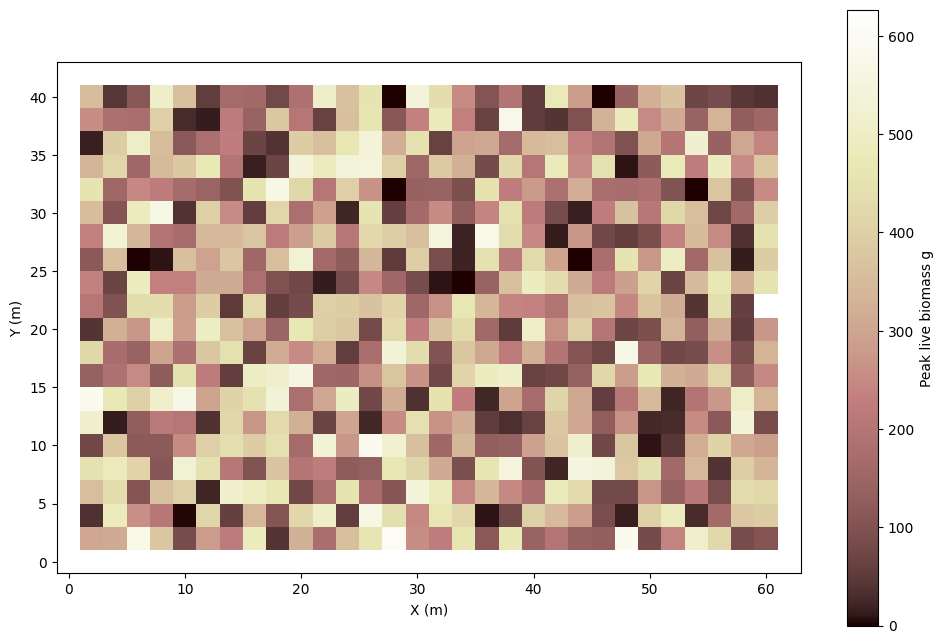

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
imshow_grid(pg, 'vegetation__live_biomass', at='cell', colorbar_label='Peak live biomass g')

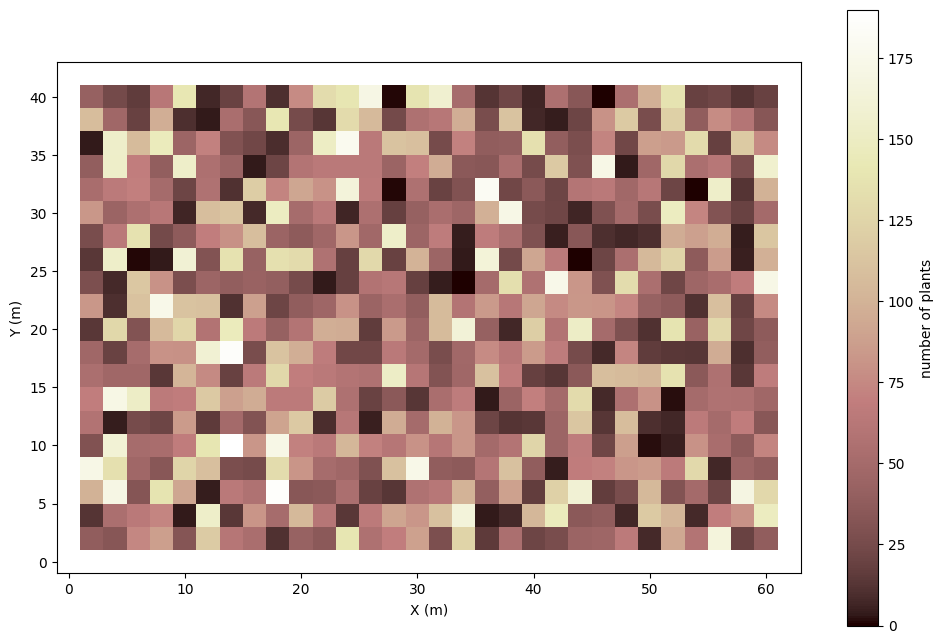

In [22]:
fig, ax = plt.subplots(figsize=(12,8))
imshow_grid(pg, 'vegetation__plant_count', at='cell', colorbar_label='number of plants')


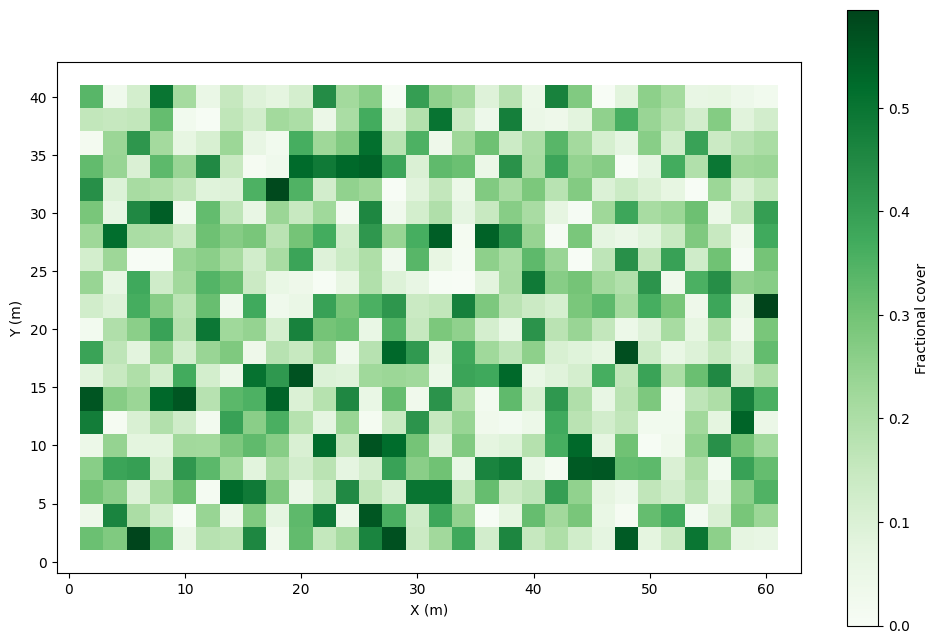

In [23]:
fig, ax = plt.subplots(figsize=(12,8))
imshow_grid(pg, 'vegetation__cover_fraction', at='cell', colorbar_label='Fractional cover', cmap='Greens')


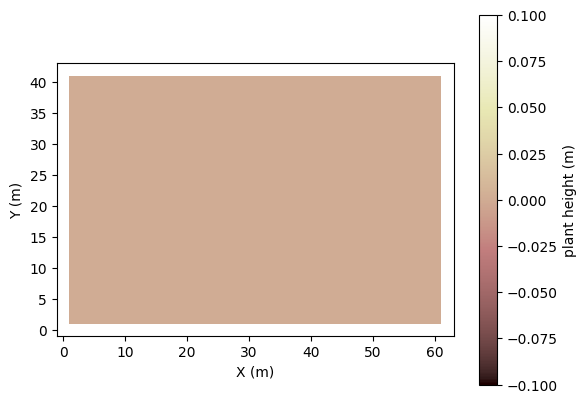

In [24]:
imshow_grid(pg, 'vegetation__plant_height', at='cell', colorbar_label='plant height (m)')

We save each species plant array separately so we can plot them individually.

In [25]:
DB=pd.DataFrame(foredune.plant_species[1].species_plants())
BTS=pd.DataFrame(foredune.plant_species[0].species_plants())

In [26]:
def print_plant_locs(filepathname, plant_locs_df_names, width_var):
    fig, ax = plt.subplots(figsize=(12,8)) #figsize in inches
    imshow_grid(pg, 'vegetation__leaf_area_index', at='cell', colorbar_label='LAI', cmap='terrain')
    ax=plt.gca()
            
    plant_locs_db=plant_locs_df_names[0][['x_loc','y_loc']].to_numpy()
    sizes_db=DB[width_var].values
    blue_patches=[]
    for idx,center in enumerate(plant_locs_db):
        circle = plt.Circle(center, sizes_db[idx], alpha=0.5, color='blue')
        blue_patches.append(circle)
        #ax.add_patch(circle)
    blue_coll=PatchCollection(blue_patches, alpha=0.7)
    blue_coll.set_color('blue')
    ax.add_collection(blue_coll)

    plant_locs_bts=plant_locs_df_names[1][['x_loc','y_loc']].to_numpy()
    sizes_bts=BTS[width_var].values
    orange_patches=[]
    for idx,center in enumerate(plant_locs_bts):
        circle = plt.Circle(center, sizes_bts[idx], alpha=0.5, color='orange')
        orange_patches.append(circle)
        #ax.add_patch(circle)

    orange_coll=PatchCollection(orange_patches, alpha=0.7)
    orange_coll.set_color('orange')
    ax.add_collection(orange_coll)
    fig.savefig(filepathname, dpi=300, bbox_inches="tight") # the bbox_inches removes whitespace around the plot

initial_plant_locs_fpath="D:\\Python\\landlab\\notebooks\\GenVeg\\figure_init_elevation.png"
print_plant_locs(initial_plant_locs_fpath, [DB,BTS], "root_sys_width")

## Main model loop script
This is the main model loop that controls the simulation that
- Advances model time 
- Updates environmental variables
- Simulates changes to vegetation communities
- Stores outputs
    - Individual plants characteristics as DataRecords
    - Grid outputs to a NetCDF format

In [27]:
temp_dir = tempfile.mkdtemp()
os.chdir(temp_dir)
save_points=[220, 220+365, 220+365+366, 220+365+366+365, 220+365+366+365+365, 220+365+366+365+365+365, 220+365+366+365+365+365+366, 220+365+366+365+365+365+366+365, 220+365+366+365+365+365+366+365+365, 220+365+366+365+365+365+366+365+365+365]
for i in range(run_length_d):
    #update temp attribute on grid
    pg.at_cell['air__max_temperature_C']= maxtemp[i]*np.ones(pg.number_of_cells)
    pg.at_cell['air__min_temperature_C']= mintemp[i]*np.ones(pg.number_of_cells)
    pg.at_cell['radiation__par_tot']= NJ_avg_par[i]*np.ones(pg.number_of_cells)
    pg.at_cell['water_surface__elevation']=water_level[i]*np.ones(pg.number_of_cells) # what are we checking here?
    pg.at_cell['elevation__above_WL']=pg.at_cell['water_surface__elevation'] - pg.at_cell['topographic__elevation']
    dist2shore=calc_dist2shore(pg)
    foredune.run_one_step()
    
    if (i in save_points):
        DB=pd.DataFrame(foredune.plant_species[1].species_plants())
        BTS=pd.DataFrame(foredune.plant_species[0].species_plants())
        #initial_plant_locs_fpath="D:\\Python\\landlab\\notebooks\\GenVeg\\figure_"+str(i)+".png"
        #print_plant_locs(initial_plant_locs_fpath, [DB,BTS], "shoot_sys_width")

    if (i/28).is_integer():
        pass
        foredune.save_output()
        #write_netcdf("dune.nc",pg, format="NETCDF3_64BIT",append=True, time=(foredune.current_day-foredune.start_date).astype(float)-1, names=['vegetation__total_biomass', 'vegetation__n_plants', 'vegetation__percent_cover', 'vegetation__cell_lai'])
        #imshow_grid(pg, 'vegetation__total_biomass', at='cell', colorbar_label='Total Biomass (g)')


4519 were too small to survive
798 were too small to survive
6 were too small to survive
4 were too small to survive
8 were too small to survive
2 were too small to survive
6 were too small to survive
3 were too small to survive
8 were too small to survive
5 were too small to survive
4 were too small to survive
6 were too small to survive
5 were too small to survive
9 were too small to survive
3 were too small to survive
5 were too small to survive
5 were too small to survive
7 were too small to survive
1 were too small to survive
6 were too small to survive
3 were too small to survive
5 were too small to survive
4 were too small to survive
8 were too small to survive
8 were too small to survive
4 were too small to survive
4 were too small to survive
7 were too small to survive
5 were too small to survive
2 were too small to survive
2 were too small to survive
5 were too small to survive
2 were too small to survive
2 were too small to survive
3 were too small to survive
3 were too smal

Now we look at some of the outputs. The get_plant_output method returns a Pandas Dataframe of the plant DataRecords. By default, all species are included but individual species can be specified as well.

In [28]:
output=foredune.get_plant_output()

To explore the output, the key order is [timestep, species, item_id]
The following shows all dune builders at timestep 0.

In [29]:
output.loc[:, 'DB',254]

,grid_element,element_id,vegetation__root_biomass,vegetation__leaf_biomass,vegetation__stem_biomass,vegetation__repro_biomass,vegetation__dead_root_biomass,vegetation__dead_leaf_biomass,vegetation__dead_stem_biomass,vegetation__dead_repro_biomass,vegetation__shoot_sys_width,vegetation__total_leaf_area,vegetation__plant_age
time,,,,,,,,,,,,,
0.0,cell,9.0,10.869358,0.000000,0.000000,0.000000,0.040642,0.000000,0.000000,0.000000e+00,0.113422,0.000000,1.0
1.0,cell,9.0,10.869358,0.000000,0.000000,0.000000,0.040642,0.000000,0.000000,0.000000e+00,0.113422,0.000000,1.0
29.0,cell,9.0,9.773428,0.000000,0.000000,0.000000,0.502217,0.000000,0.000000,0.000000e+00,0.113422,0.000000,29.0
57.0,cell,9.0,8.584463,0.000000,0.000000,0.000000,0.621641,0.000000,0.000000,0.000000e+00,0.113422,0.000000,57.0
85.0,cell,9.0,7.233640,0.000000,0.000000,0.000000,0.715360,0.000000,0.000000,0.000000e+00,0.113422,0.000000,85.0
113.0,cell,9.0,5.778565,0.000000,0.000000,0.000000,0.784442,0.000000,0.000000,0.000000e+00,0.113422,0.000000,113.0
141.0,cell,9.0,1.401693,1.479807,1.133761,0.000009,1.423428,0.241576,0.218630,0.000000e+00,0.183415,0.010273,141.0
169.0,cell,9.0,0.000000,0.000000,0.000000,0.000000,1.017367,0.898538,0.687981,6.458423e-06,0.181697,0.009634,146.0
197.0,cell,9.0,0.000000,0.000000,0.000000,0.000000,0.143305,0.126567,0.096908,9.097233e-07,0.181697,0.009634,146.0


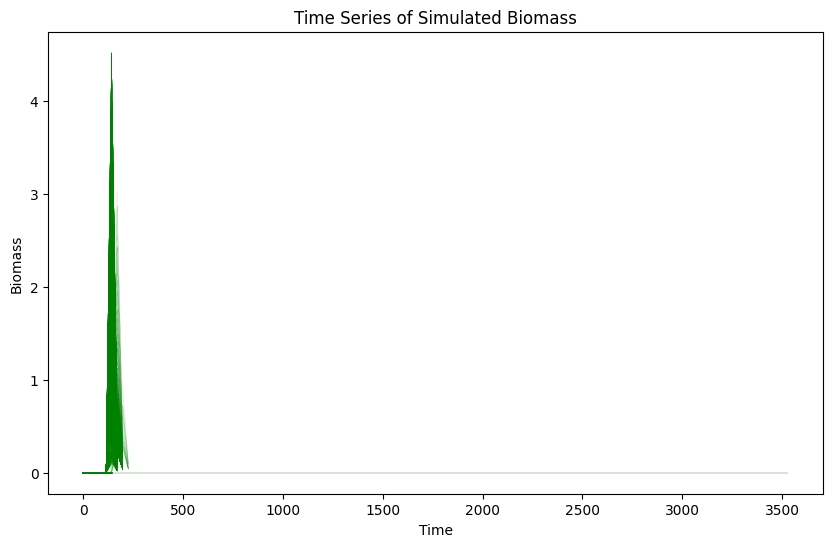

In [30]:
DB=output.loc[:,'DB',:]
DB_np=DB['vegetation__dead_leaf_biomass']
cs=DB_np.reorder_levels(['item_id','time']).sort_index()
groups = cs.groupby(level=0)

plt.figure(figsize=(10, 6))
for item, group in groups:
    x = group.index.get_level_values(1)
    y = group.values
    plt.plot(x, y, linewidth=0.1, color='green', alpha=0.25)

plt.xlabel('Time')
plt.ylabel('Biomass')
plt.title('Time Series of Simulated Biomass')
plt.show()

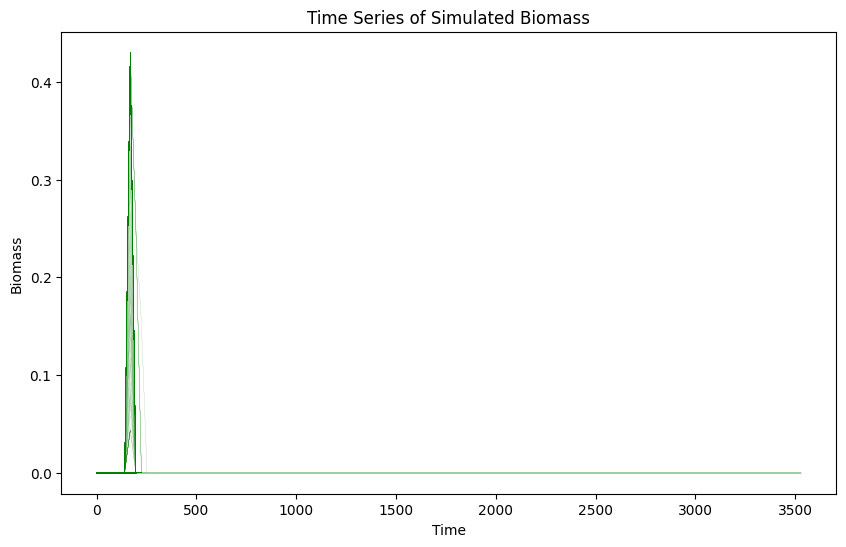

In [31]:
BTS=output.loc[:,'BTS',:]
#fig, ax = plt.subplots()
#ax.set_xlim(0,2045)
#ax.set_ylim(0,10)
BTS_np=BTS['vegetation__leaf_biomass']
cs=BTS_np.reorder_levels(['item_id','time']).sort_index()
groups = cs.groupby(level=0)

plt.figure(figsize=(10, 6))
for item, group in groups:
    x = group.index.get_level_values(1)
    y = group.values
    plt.plot(x, y, linewidth=0.1, color='green', alpha=0.25)

plt.xlabel('Time')
plt.ylabel('Biomass')
plt.title('Time Series of Simulated Biomass')
plt.show()

Here we look at some outputs at the final time step. Note that the final timestep may be in dormant season so biomass represents only the persistent parts. The number of plants is still tracked but annual plants are removed.

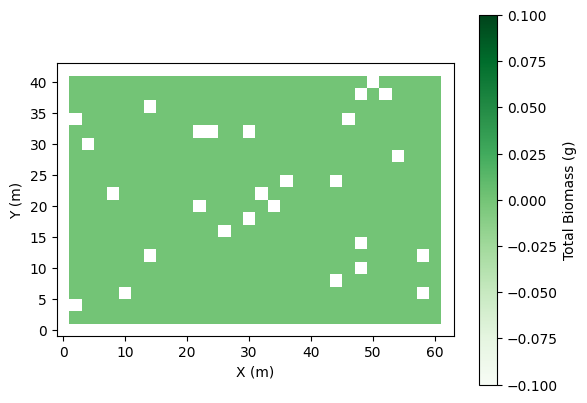

In [32]:
imshow_grid(pg, 'vegetation__live_biomass', at='cell', colorbar_label='Total Biomass (g)', cmap='Greens')

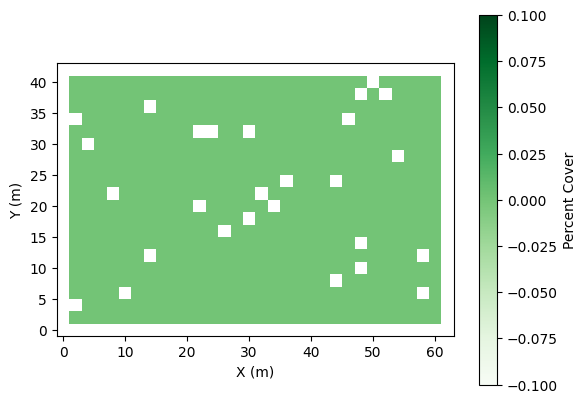

In [33]:
imshow_grid(pg, 'vegetation__cover_fraction', at='cell', colorbar_label='Percent Cover', cmap='Greens')

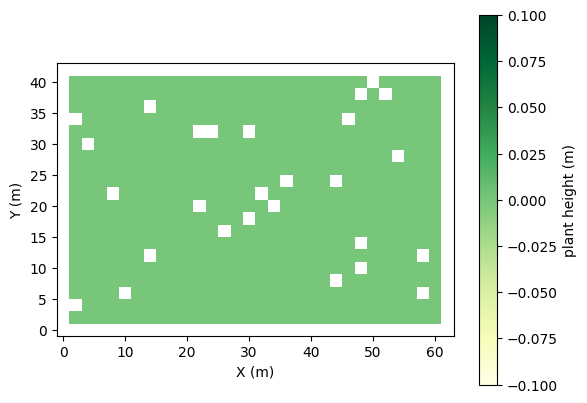

In [34]:
imshow_grid(pg, 'vegetation__plant_height', at='cell', colorbar_label='plant height (m)', cmap='YlGn')

grid.close()

In [35]:
grid = netcdf_file('dune.nc', 'r')
print(grid.variables['vegetation__live_biomass'][15])

FileNotFoundError: [Errno 2] No such file or directory: 'dune.nc'

In [ ]:
dune_grid = read_netcdf('dune.nc','r')